In [1]:
from IPython.display import IFrame

In [2]:
IFrame('https://finnhub.io/dashboard', width = 800, height = 450)

## Path 1 uses a Finnhub API Key (not provided here). If you have a finnhub API key, enter it below and proceed

### Otherwise, scroll down to Path Two to follow the same process with the provided CSVs


## Path 1:

### Import Packages

In [3]:
import requests
from bs4 import BeautifulSoup
import finnhub
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np


In [4]:
apikey = "Your_API_Here"

### Ticker Selection

#### The filter_tickers_with_peTTM checks whether each ticker in the user-entered list has a Price to Earnings ratio. Because PE is needed to calculate intrinsic value, any tickers without a PE are removed from the list.

Finnhub is limited to 60 API Calls per minute, please limit list to under four tickers

In [5]:
#user inputs stock list
#input continues until stop command evoked
ticker_list = []
while True:
    ticker_selection = input("Enter Ticker or type 'stop'").upper()
    ticker_list.append(ticker_selection)
    if ticker_selection == "STOP":
        break
ticker_list = ticker_list[:-1]
print('Selected tickers: ', ticker_list)

def filter_tickers_with_peTTM(ticker_list):
    valid_tickers = []

    for ticker in ticker_list:
        try:
            financials = finnhub.Client(api_key=apikey).company_basic_financials(ticker, 'all')
            peTTM = financials.get('metric', {}).get('peTTM')
            if peTTM is not None:
                valid_tickers.append(ticker)
        except Exception as e:
            print(f"Error for {ticker}: {str(e)}")

    return valid_tickers

filtered_tickers = filter_tickers_with_peTTM(ticker_list)

if not filtered_tickers:
    print("No tickers with 'peTTM' found.")
else:
    print(f"Filtered tickers with 'peTTM': {filtered_tickers}")


Enter Ticker or type 'stop' AAPL
Enter Ticker or type 'stop' AMZN
Enter Ticker or type 'stop' HAE
Enter Ticker or type 'stop' NOC
Enter Ticker or type 'stop' stop


Selected tickers:  ['AAPL', 'AMZN', 'HAE', 'NOC']
Filtered tickers with 'peTTM': ['AAPL', 'AMZN', 'HAE', 'NOC']


In [6]:
#this request establishes market constants to be evaluated against filtered_tickers 

#United States Treasury API pulls TNote rate
treasuryurl = 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/avg_interest_rates?fields=avg_interest_rate_amt&filter=record_date:eq:2023-10-31,security_desc:eq:Treasury Notes'
response = requests.get(treasuryurl)
data = response.json()
rate = data['data'][0]['avg_interest_rate_amt']
print(rate)


2.190


### Primary Calculations via API requests begin here: Open Price, Current Price, Earnings per Share, and Price to Earnings.

In [7]:
#this set of requests establishes Company Metrics to be evaluated against filtered_tickers 

#Finnhub API requests financial metrics and share price
def opfunc(ticker):
    finnhub_client = finnhub.Client(api_key=apikey)
    financials = finnhub_client.company_basic_financials(ticker, 'all')
    quote = finnhub_client.quote(ticker)
    return float(quote['o'])

def cpfunc(ticker):
    finnhub_client = finnhub.Client(api_key=apikey)
    financials = finnhub_client.company_basic_financials(ticker, 'all')
    quote = finnhub_client.quote(ticker)
    return float(quote['c'])

def epsfunc(ticker):
    finnhub_client = finnhub.Client(api_key=apikey)
    financials = finnhub_client.company_basic_financials(ticker, 'all')
    quote = finnhub_client.quote(ticker)
    return float(financials['metric']['epsTTM'])

def pefunc(ticker):
    finnhub_client = finnhub.Client(api_key=apikey)
    financials = finnhub_client.company_basic_financials(ticker, 'all')
    quote = finnhub_client.quote(ticker)
    return float(financials['metric']['peTTM'])




### Five year growth projections are scraped via beautiful soup for each item in the list.

In [8]:
# Yahoo Finance scrape for 5-year projections
def fiveyear(ticker):
    ybaseurl = 'https://finance.yahoo.com/quote/' + ticker + '/analysis?p=' + ticker
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/113.0'}
    r = requests.get(ybaseurl, headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    forecast = soup.find('section', {'class': 'smartphone_Px(20px) smartphone_Pt(10px)'}).text

    nfy = forecast.find('Next 5 Years (per annum)')
    startindex = nfy + 24
    endindex = forecast.find('%', startindex)
    return float(forecast[startindex:endindex])


### Intrinsic Value, Buy Price, and Recommendations Calculated

In [9]:
# Calculate
# Intrinsic Value

def intV(ticker):
    return epsfunc(i) * (1 + (fiveyear(i) * 0.01 * 0.75)) * pefunc(i)

#Buy Price
def bp(ticker):
    return round(0.75 * intV(i), 2)

# Recommendations
def rec(ticker):
    if cpfunc(i) < intV(i) and cpfunc(i) >= bp(i):
        return 'Soft Buy'
    elif cpfunc(i) < bp(i):
        return 'Strong Buy'
    else:
        return 'No Buy'


### Previous functions are called and the results  are gathered into a dictionary with the tickers as keys - then converted to a Pandas DF.

In [10]:
#Creating aggregated DF

#df = pd.DataFrame(columns = ['Ticker', 'Open Price', 'Current Price', 'Earnings per Share', 'Price to Earning Ratio'])
tickerdict = {}
for i in filtered_tickers :
    tickerdict[i] = opfunc(i), cpfunc(i), pefunc(i), epsfunc(i), fiveyear(i), intV(i), bp(i), rec(i)
#print(testdict)
#df = pd.DataFrame(columns = ['ticker', '', 'current price', 'price to earnings', 'earnings per share', '5-year projection'])    
df = pd.DataFrame.from_dict(tickerdict)
df= df.T
df = df.rename(columns={0: 'open price', 1: 'current price', 2: 'price to earnings', 3: 'earnings per share', 4: 'five year projection', 5: 'intrinsic value', 6: 'Buy price', 7: 'recommendation'})
print(df)
#df.to_csv('ATAM.csv')

     open price current price price to earnings earnings per share  \
AAPL     190.25        189.69           30.3775             6.1296   
AMZN     142.66        145.18           73.7005             1.9155   
HAE       88.52         83.21           35.3837             2.5072   
NOC      464.34        464.17           15.0111            30.4533   

     five year projection intrinsic value Buy price recommendation  
AAPL                 6.14      194.776523    146.08       Soft Buy  
AMZN                 87.0      233.288891    174.97     Strong Buy  
HAE                  10.0       95.367564     71.53       Soft Buy  
NOC                   1.9      463.651741    347.74         No Buy  


### Added calculation to determine what percent of your investable cash should be allocated to your selected firm.

In [11]:

df['% allocation'] = 0  # Initialize the column with zeros
df.loc[df['recommendation'] == 'No Buy', '% allocation'] = 0
df.loc[df['recommendation'] == 'Soft Buy', '% allocation'] = 1
df.loc[df['recommendation'] == 'Strong Buy', '% allocation'] = 2
total_allocation = df['% allocation'].sum()
df['% allocation'] = round(df['% allocation'] / total_allocation * 100, 2)
df.head()

,open price,current price,price to earnings,earnings per share,five year projection,intrinsic value,Buy price,recommendation,% allocation
AAPL,190.25,189.69,30.3775,6.1296,6.14,194.776523,146.08,Soft Buy,25.0
AMZN,142.66,145.18,73.7005,1.9155,87.0,233.288891,174.97,Strong Buy,50.0
HAE,88.52,83.21,35.3837,2.5072,10.0,95.367564,71.53,Soft Buy,25.0
NOC,464.34,464.17,15.0111,30.4533,1.9,463.651741,347.74,No Buy,0.0


## Visuals

These candles represent the open price versus the current price (dummy numbers in the CSV). Green indicates positive price action, red indicates negative price action.

Y axis labels represent open and current prices

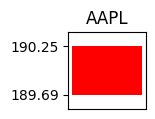

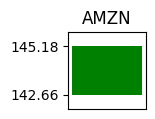

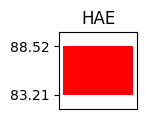

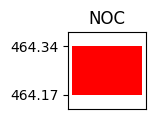

In [12]:
#candles at a glance

color1 = 'green'
color2 = 'red'
width = 0.2 
fig_size = (1, 1)

#iterate over rows and create individual plots
for i, (index, row) in enumerate(df.iterrows()):
    plt.figure(figsize=fig_size)  # Set the size of each plot
    current_price = row['current price']
    open_price = row['open price']
    
    if current_price >= open_price:
        plt.bar(0, current_price - open_price, width, bottom=open_price, color=color1)
    else:
        plt.bar(0, open_price - current_price, width, bottom=current_price, color=color2)

    plt.title(index)
    ylim_lower = min(open_price, current_price) - 0.3 * abs(current_price - open_price)
    ylim_upper = max(open_price, current_price) + 0.3 * abs(current_price - open_price)
    plt.ylim(ylim_lower, ylim_upper)
    plt.yticks([open_price, current_price])
    plt.xticks([])
    plt.show()



### Buy price ratio simply indicates risk tolerance. As the proportion of the buy price to current price decreases, the likelihood that the share value (within the confines of this analysis) is inflated.

C:\Users\12027\AppData\Local\Temp\ipykernel_5940\701833561.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bars = plt.bar(rows[sorted_indices], buy_price_ratio[sorted_indices], color=[colors[rec] for rec in df['recommendation'][sorted_indices]], edgecolor='black')
C:\Users\12027\AppData\Local\Temp\ipykernel_5940\701833561.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for bar, ratio, rec in zip(bars, buy_price_ratio[sorted_indices], df['recommendation'][sorted_indices]):


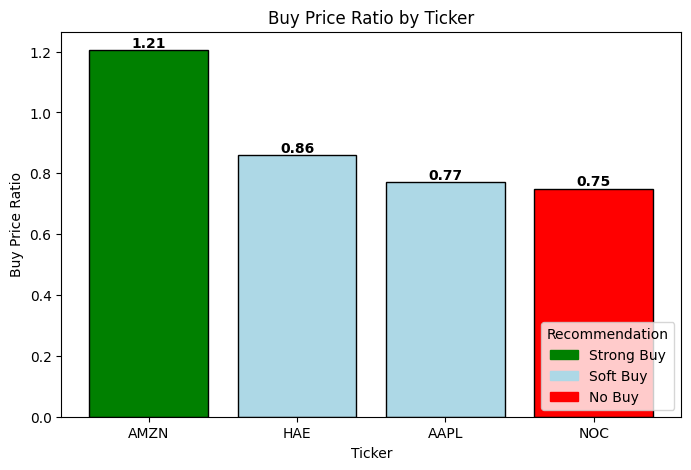

In [13]:
#Buy Price to Current Price Ratio

# Extracting row indices and recommendation values
rows = df.index
buy_price_ratio = df['Buy price'] / df['current price']

# Sorting indices based on the buy price ratio in descending order
sorted_indices = buy_price_ratio.argsort()[::-1]

# Mapping recommendation categories to colors
colors = {'Strong Buy': 'green', 'Soft Buy': 'lightblue', 'No Buy': 'red'}

plt.figure(figsize=(8, 5))
bars = plt.bar(rows[sorted_indices], buy_price_ratio[sorted_indices], color=[colors[rec] for rec in df['recommendation'][sorted_indices]], edgecolor='black')

plt.title('Buy Price Ratio by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Buy Price Ratio')

for bar, ratio, rec in zip(bars, buy_price_ratio[sorted_indices], df['recommendation'][sorted_indices]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{ratio:.2f}', ha='center', va='bottom', color='black', weight='bold')
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[rec]) for rec in colors]
plt.legend(legend_handles, colors.keys(), title='Recommendation', loc='lower right')

plt.show()


### Adding a simple pie chart to represent suggested allocation of the analyzed tickers

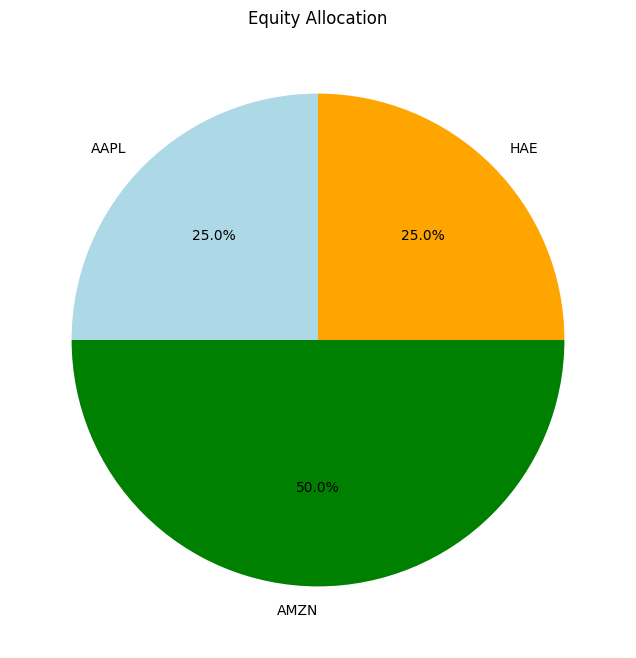

In [14]:
filtered_ticker = df[df['% allocation'] > 0]

plt.figure(figsize=(8, 8))
plt.pie(filtered_ticker['% allocation'], labels=filtered_ticker.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'green', 'orange', 'yellow'])
plt.title('Equity Allocation')
plt.show()


## Path 2

#### Import Packages

In [2]:
import requests
from bs4 import BeautifulSoup
import finnhub
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np

### Choose any Combination of 'AMZN', 'AAPL', 'TSLA', and 'MPC'

In [3]:
stock_names = ["AAPL", "AMZN", "TSLA", "MPC"]
combined_data = pd.DataFrame()
user_input = input("Enter a combination of stock names (comma-separated): ")
selected_stocks = [stock.strip().upper() for stock in user_input.split(',')]

#check if the user input is valid
invalid_stocks = set(selected_stocks) - set(stock_names)
if invalid_stocks:
    print(f"Invalid stock names: {', '.join(invalid_stocks)}")
else:
    for stock_name in selected_stocks:
        csv_filename = f"{stock_name}.csv"
        try:
            # Read the CSV file and concatenate the data to the combined DataFrame
            stock_data = pd.read_csv(csv_filename)
            combined_data = pd.concat([combined_data, stock_data], ignore_index=True)
        except FileNotFoundError:
            print(f"CSV file not found for {stock_name}")

# Display the combined DataFrame
combined_data.head()



Enter a combination of stock names (comma-separated):  TSLA, AAPL, MPC


,Unnamed: 0,open price,current price,price to earnings,earnings per share
0,TSLA,241.19,237.79,69.1800,3.1034
1,AAPL,188.10,187.97,30.0087,6.1296
2,MPC,147.30,150.19,4.8242,26.7856


In [39]:
combined_data = combined_data.rename(columns={"Unnamed: 0": "ticker"})

### Scraping 5-Year Growth Projection

In [40]:
# Yahoo Finance scrape for 5-year projections
def fiveyear(ticker):
    ybaseurl = 'https://finance.yahoo.com/quote/' + ticker + '/analysis?p=' + ticker
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/113.0'}
    r = requests.get(ybaseurl, headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    forecast = soup.find('section', {'class': 'smartphone_Px(20px) smartphone_Pt(10px)'}).text

    nfy = forecast.find('Next 5 Years (per annum)')
    startindex = nfy + 24
    endindex = forecast.find('%', startindex)
    return float(forecast[startindex:endindex])

### Adding growth projection field to df

In [41]:
combined_data['5-year growth projection'] = combined_data['ticker'].apply(fiveyear)
combined_data.head()

,ticker,open price,current price,price to earnings,earnings per share,5-year growth projection
0,AMZN,147.13,147.036,73.3866,1.9155,87.00
1,AAPL,188.10,187.970,30.0087,6.1296,6.14
2,TSLA,241.19,237.790,69.1800,3.1034,3.63
3,MPC,147.30,150.190,4.8242,26.7856,-15.33


### IV calculation, buy price, and recommendations
Intrinsic value is based on the Graham Equation, though a future iteration should include a discounted cash flow formula

The buy price indicates the price at which you could buy a share for 75% of the calculated instrinsic value. The 75% is correlated to each investor's own risk tolerance. A 50% discount wouldr esult in potentially zero buy signals, but 95% does not offer much hedging if market forces turn

In [42]:
#calculations
#intrinsic Value
def intV(row):
    eps_value = row['earnings per share']
    fiveyear_value = row['5-year growth projection']
    pe_value = row['price to earnings']
    return eps_value * (1 + (fiveyear_value * 0.01 * 0.75)) * pe_value

#buy Price
def bp(row):
    intrinsic_value = row['intrinsic value']
    return round(0.75 * intrinsic_value, 2)

#recommendation
def rec(row):
    current_price = row['current price']
    intrinsic_value = row['intrinsic value']
    buy_price = row['buy price']

    if current_price < intrinsic_value and current_price >= buy_price:
        return 'Soft Buy'
    elif current_price < buy_price:
        return 'Strong Buy'
    else:
        return 'No Buy'

### Applying the functions to the df and adding an allocation percent

The % allocation calculates how much of your cash pool you should invest in each of the analyzed tickers
Strong Buy's are always 2x allocation of Soft Buy's.

In [44]:
combined_data['intrinsic value'] = combined_data.apply(intV, axis=1)
combined_data['buy price'] = combined_data.apply(bp, axis=1)
combined_data['recommendation'] = combined_data.apply(rec, axis=1)
combined_data['% allocation'] = 0  # Initialize the column with zeros
combined_data.loc[combined_data['recommendation'] == 'No Buy', '% allocation'] = 0
combined_data.loc[combined_data['recommendation'] == 'Soft Buy', '% allocation'] = 1
combined_data.loc[combined_data['recommendation'] == 'Strong Buy', '% allocation'] = 2
total_allocation = combined_data['% allocation'].sum()
combined_data['% allocation'] = round(combined_data['% allocation'] / total_allocation * 100, 2)
combined_data.head()

,ticker,open price,current price,price to earnings,earnings per share,5-year growth projection,intrinsic value,buy price,recommendation,% allocation
0,AMZN,147.13,147.036,73.3866,1.9155,87.00,232.295283,174.22,Strong Buy,66.67
1,AAPL,188.10,187.970,30.0087,6.1296,6.14,192.411826,144.31,Soft Buy,33.33
2,TSLA,241.19,237.790,69.1800,3.1034,3.63,220.538235,165.40,No Buy,0.00
3,MPC,147.30,150.190,4.8242,26.7856,-15.33,114.362126,85.77,No Buy,0.00


### Visuals to provide a snapshot of the findings

These candles represent the open price versus the current price (dummy numbers in the CSV). Green indicates positive price action, red indicates negative price action.

Y axis labels represent open and current prices

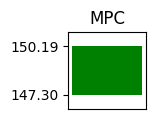

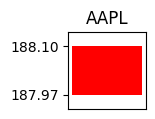

In [32]:
#candles at a glance

color1 = 'green'
color2 = 'red'
width = 0.2 
fig_size = (1, 1)

#iterate over rows
for i, (index, row) in enumerate(combined_data.iterrows()):
    plt.figure(figsize=fig_size)  # Set the size of each plot
    current_price = row['current price']
    open_price = row['open price']
    
    if current_price >= open_price:
        plt.bar(0, current_price - open_price, width, bottom=open_price, color=color1)
    else:
        plt.bar(0, open_price - current_price, width, bottom=current_price, color=color2)

    plt.title(combined_data.loc[index, 'ticker'])
    ylim_lower = min(open_price, current_price) - 0.3 * abs(current_price - open_price)
    ylim_upper = max(open_price, current_price) + 0.3 * abs(current_price - open_price)
    plt.ylim(ylim_lower, ylim_upper)
    plt.yticks([open_price, current_price])
    plt.xticks([])
    plt.show()

### Buy price ratio simply indicates risk tolerance. As the proportion of the buy price to current price decreases, the likelihood that the share value (within the confines of this analysis) is inflated.

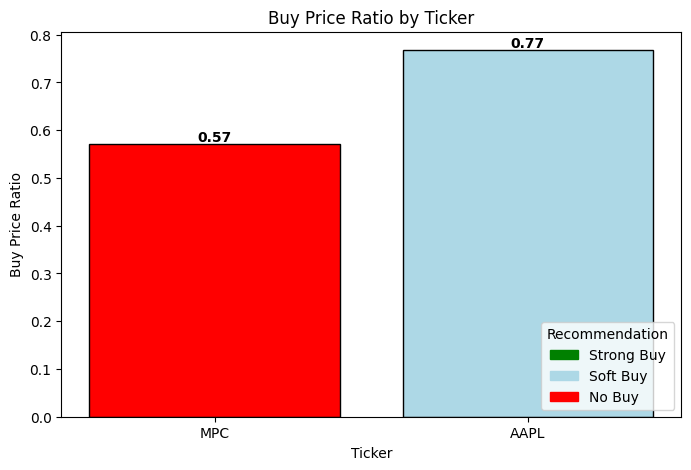

In [36]:
#buy Price to Current Price Ratio
rows = combined_data.index
buy_price_ratio = combined_data['buy price'] / combined_data['current price']

#sort indices based on the buy price ratio in descending order
sorted_indices = buy_price_ratio.argsort()[::-1]


colors = {'Strong Buy': 'green', 'Soft Buy': 'lightblue', 'No Buy': 'red'}
plt.figure(figsize=(8, 5))
bars = plt.bar(sorted_indices, buy_price_ratio.iloc[sorted_indices], color=[colors[rec] for rec in combined_data['recommendation'].iloc[sorted_indices]], edgecolor='black')
plt.title('Buy Price Ratio by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Buy Price Ratio')
plt.xticks(sorted_indices, [combined_data.loc[index, 'ticker'] for index in sorted_indices])

for bar, ratio, rec, index in zip(bars, buy_price_ratio.iloc[sorted_indices], combined_data['recommendation'].iloc[sorted_indices], sorted_indices):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{ratio:.2f}', ha='center', va='bottom', color='black', weight='bold')

legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[rec]) for rec in colors]
plt.legend(legend_handles, colors.keys(), title='Recommendation', loc='lower right')

plt.show()


### Adding a simple pie chart to represent suggested allocation of the analyzed tickers

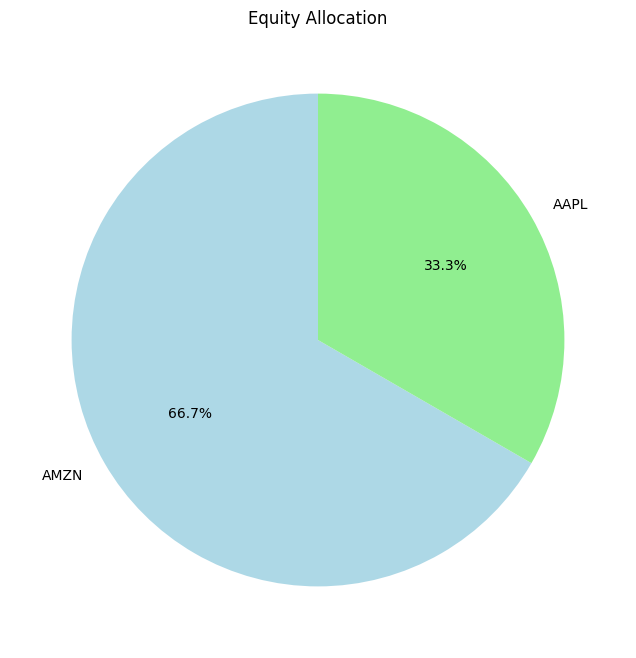

In [48]:
filtered_tickers = combined_data[combined_data['% allocation'] > 0]
plt.figure(figsize=(8, 8))
plt.pie(filtered_tickers['% allocation'], labels=filtered_data['ticker'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Equity Allocation')
plt.show()